In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [241]:
coef = np.load('coef.npy')
coef[0:5]

array([ 0.00342922, -0.00667328, -0.00868971, -0.        , -0.00362185])

In [242]:
features_df = pd.read_csv("features_binned.csv")
cols = features_df.columns
cols

Index(['Unnamed: 0', '+ve strand', 'length', 'longest A', 'longest C',
       'longest G', 'longest T', 'As', 'Cs', 'Gs',
       ...
       'G_comp_0.8', 'G_comp_0.9', 'length_21', 'length_22', 'length_23',
       'length_24', 'length_25', 'length_26', 'length_27', 'length_28'],
      dtype='object', length=580)

In [243]:
cols = np.array(cols)
cols = cols.reshape(cols.shape[0])

In [244]:
# TODO: bin: length, base runs, fraction of each base

In [245]:
def find_cols(keyword, title):
    dist_indices = [keyword in colname for index, colname in enumerate(cols)]
    dist_name = cols[dist_indices]
    dist_coef = coef[dist_indices]
    plt.bar(dist_name, dist_coef)
    plt.ylim((-0.1, 0.1))
    plt.title(title)

In [246]:
find_cols('length', 'Length of sgRNA')

IndexError: boolean index did not match indexed array along dimension 0; dimension is 501 but corresponding boolean dimension is 580

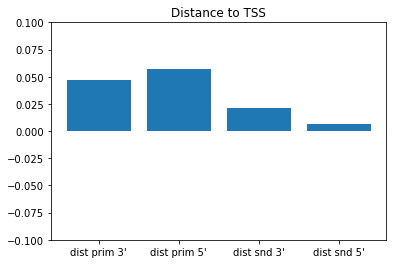

In [202]:
# TODO: add standard deviation error bars 
# TODO: fix labels
find_cols('dist', 'Distance to TSS')

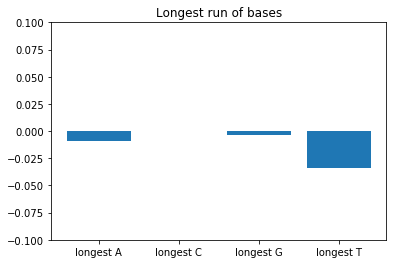

In [203]:
find_cols('longest', 'Longest run of bases')

Text(0.5,1,'Strand Targeted')

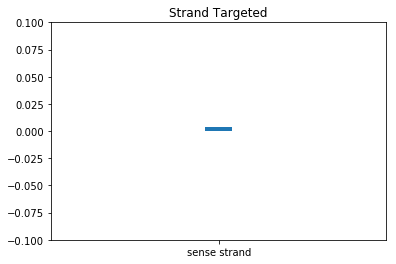

In [200]:
dist_indices = ['+ve' in colname for index, colname in enumerate(cols)]
dist_name = cols[dist_indices]
dist_coef = coef[dist_indices]
plt.bar('sense strand', dist_coef)
plt.ylim((-0.1, 0.1))
plt.xlim((-5, 5))
plt.title('Strand Targeted')

In [ ]:
# change names to be better on axes 
# make mini graphs with each color at eahc positions
# group, facet 

In [85]:
# Regular expression which returns a boolean if the column name is for a nucleotide position
def find_nucl_pos(string):
    prog = re.compile('pos_[0-9]+_[A-Z]$')
    result = prog.match(string)
    return bool(result)

In [82]:
# Regular expression which returns a boolean if the column name is for a dimer position
def find_dimer_pos(string):
    prog = re.compile('pos_[0-9]+_[A-Z][A-Z]$')
    result = prog.match(string)
    return bool(result)

In [81]:
nucl_pos_bool = [find_nucl_pos(name) for name in cols]
dimer_pos_bool = [find_dimer_pos(name) for name in cols]

In [107]:
def get_pos(string):
    return int(re.findall('[0-9]+', string)[0])

In [128]:
# Extract out position elements
nucl_pos_names = cols[nucl_pos_bool]
nucl_pos = [get_pos(name) for name in nucl_pos_names]

dimer_pos_names = cols[dimer_pos_bool]
dimer_pos = [get_pos(name) for name in dimer_pos_names]

In [187]:
nucl_coef = coef[nucl_pos_bool]
dimer_coef = coef[dimer_pos_bool]

In [143]:
def specific_nucl_pos(nucleotide):
    pos_bool = [nucleotide in name for name in nucl_pos_names]
    names = nucl_pos_names[pos_bool]
    pos = [get_pos(name) for name in names]
    coef = nucl_coef[pos_bool]
    return (names, pos, coef)

In [185]:
A_pos_names, A_pos, A_coef = specific_nucl_pos('A')
C_pos_names, C_pos, C_coef = specific_nucl_pos('C')
G_pos_names, G_pos, G_coef = specific_nucl_pos('G')
T_pos_names, T_pos, T_coef = specific_nucl_pos('T')

In [149]:
A = specific_nucl_pos('A')
C = specific_nucl_pos('C')
G = specific_nucl_pos('G')
T = specific_nucl_pos('T')
nucl_pos_plot = [A, C, G, T]

In [168]:
from matplotlib.pyplot import figure

In [236]:
def pos_plot(plot_info, colors, title, legend):
    width = 1/len(plot_info)
    figure(figsize=(10,5))
    for index, nucl in enumerate(plot_info):
        plt.bar(np.array(nucl[1]) + (index - 1)*width, nucl[2] + 0.0003, width, color = colors[index])

    plt.legend(legend)
    plt.xticks(np.arange(len(nucl[1])))
    plt.ylim((-0.1, 0.1))
    plt.title(title)
    plt.show()

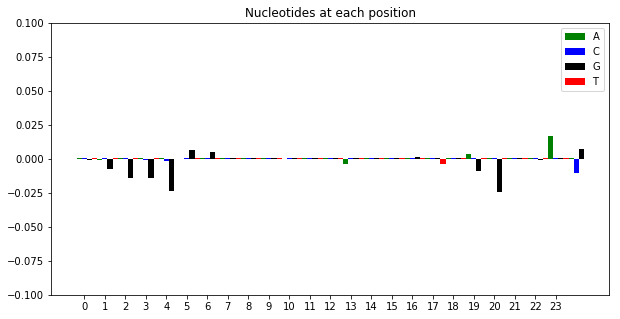

In [237]:
pos_plot(nucl_pos_plot, ['g', 'b', 'k', 'r'], "Nucleotides at each position", ('A', 'C', 'G', 'T'))

In [219]:
np.arange(0,1,1/len(dimer))

array([0.        , 0.33333333, 0.66666667])

In [223]:
len(dimer_plot)

16

In [209]:
def specific_dimer_pos(dimer):
    pos_bool = [dimer in name for name in dimer_pos_names]
    names = dimer_pos_names[pos_bool]
    pos = [get_pos(name) for name in names]
    curr_coef = dimer_coef[pos_bool]
    return (names, pos, curr_coef)

In [210]:
dimer_encodings = {'AA' : 0, 'AC' : 1, 'AG' : 2, 'AT' : 3, 'CA' : 4, 'CC' : 5, 'CG' : 6, 'CT' : 7,          
                   'GA' : 8, 'GC' : 9, 'GG' : 10, 'GT' : 11, 'TA' : 12, 'TC' : 13, 'TG' : 14, 'TT' : 15}
dimers = dimer_encodings.keys()
dimer_plot = []
for dimer in dimers:
    dimer_plot.append(specific_dimer_pos(dimer))

In [232]:
colors = ['#00FF00', '#66FF66', '#99FF99', '#CCFFCC',
         '#000099', '#0000FF', '#3333FF','#6666FF',
         '#000000', '#404040', '#808080', '#C0C0C0',
         '#CC0000', '#FF6666', '#FF9999', '#FFCCCC']

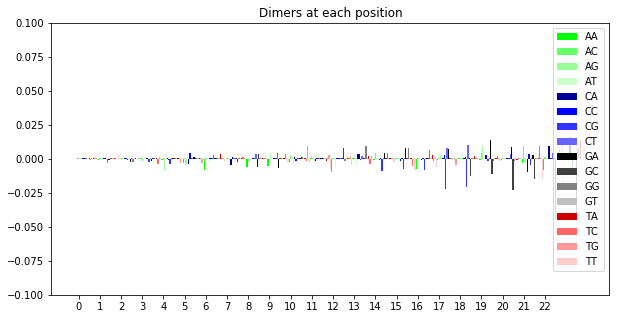

In [238]:
# Note: they label the big ones with the dimer name
# Program? Adobe? 
# color blind palette?? 
pos_plot(dimer_plot, colors,"Dimers at each position", dimers)